# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
import plotly.express as px
from sklearn.metrics import roc_curve, auc
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1500)

In [2]:
try:
  df = pd.read_csv('/DS/Yandex_Practikum/Projects/datasets/Churn_Modelling.csv')
except:
  df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


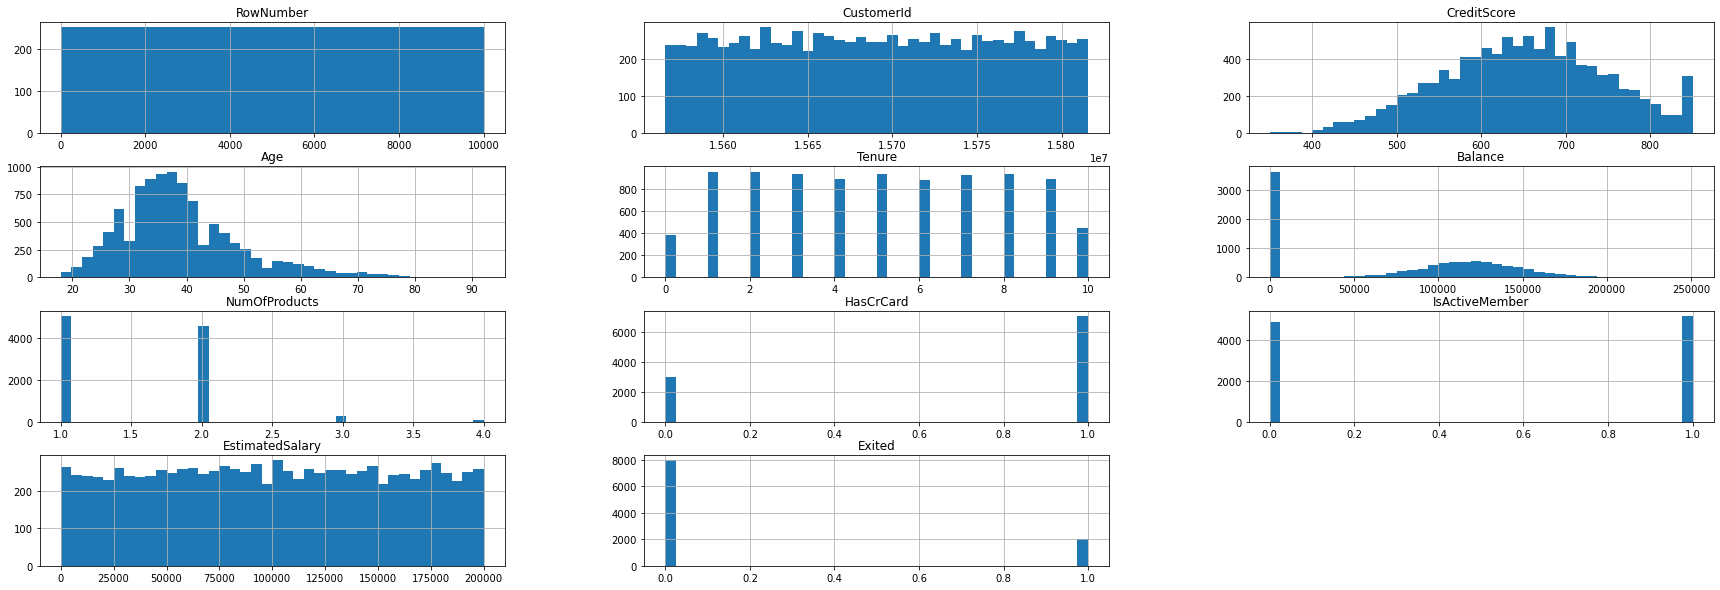

In [4]:
df.hist(figsize=(30,10), bins = 40)
None

In [5]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['Tenure'].median()

5.0

In [8]:
df['Tenure'].mean()

4.997690023099769

Заменю пропуски медианным значением

In [9]:
df.loc[df['Tenure'].isna(),'Tenure'] = df['Tenure'].median()

В датасете пропуски отработали и полные дупликаты отсутсвуют. Данные распределены по большей части равномерно и нормально.

Подготовим исходные данные для обчения модели. 

In [10]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'], dtype='object')

Целевой признак будет столбец - 'Exited'. Признаки будут столбы - 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'. Остальные столбца в обучении роли не сыграют.

In [11]:
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Выполним прямое кодирование, чтобы преобразовать категориальные признаки, столбцы - 'Geography', 'Gender'.

In [12]:
data_ohe = pd.get_dummies(df_model, drop_first=True)

In [13]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify = target_valid)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(5000, 11)
(2500, 11)
(2500, 11)
(5000,)
(2500,)
(2500,)


# Исследование задачи

Создам датафрейм для подведения итоговы результатов исследования

In [14]:
conclusion = pd.DataFrame(columns=[('methods','upsample'), ('methods','scaler'), ('methods','class_weight'),('results','best_model'),('results','f1_score')])
conclusion.columns = pd.MultiIndex.from_tuples(conclusion.columns)

In [15]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [16]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = (f1_score(target_valid,predicted_valid))
if result > best_result:
    best_result = result
    best_model = model

In [17]:
print(best_model)
print(best_result)

LogisticRegression(random_state=12345, solver='liblinear')
0.06666666666666668


Дерево решений класификации

In [18]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = (f1_score(target_valid,predicted_valid))
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 234 ms
Wall time: 235 ms


In [19]:
print(best_model)
print(best_result)

DecisionTreeClassifier(max_depth=7, random_state=12345)
0.5669856459330144


Случайный лес классифифкации.

In [20]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'])
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [21]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345)
Лучний результат, F1: 0.587088915956151


Проверим модель на тестовой выборке.

In [22]:
model = best_model
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.5744934445768772


Без применения методов борьбы с дисбалансом лучшая модель - RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345) с F1 - 0.5744934445768772.

In [23]:
conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'-',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\3672044082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'-',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


## Борьба с дисбалансом

### Увеличение выборки

In [24]:
features_zeros  = features_train[target_train == 0] 
features_ones = features_train[target_train == 1] 
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(3981, 11)
(1019, 11)
(3981,)
(1019,)


Увеличим выборку. Добавим features_ones и target_ones

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 3)

features_zeros  = features_train_upsampled[target_train == 0] 
features_ones = features_train_upsampled[target_train == 1] 
target_zeros = target_train_upsampled[target_train == 0]
target_ones = target_train_upsampled[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(3981, 11)
(3057, 11)
(3981,)
(3057,)


C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\1886815137.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_zeros  = features_train_upsampled[target_train == 0]
C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\1886815137.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_ones = features_train_upsampled[target_train == 1]


#### Проверка моделей

In [26]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [27]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid,predicted_valid)
if result > best_result:
    best_result = result
    best_model = model

In [28]:
print(best_model)
print(best_result)

LogisticRegression(random_state=12345, solver='liblinear')
0.4312449145646867


Дерево решений класификации

In [29]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 297 ms
Wall time: 272 ms


In [30]:
print(best_model)
print(best_result)

DecisionTreeClassifier(max_depth=5, random_state=12345)
0.5852895148669797


Случайный лес классифифкации. Исходя из результатов модели "Дерево решений класификации" глубину леса выставим - 5

In [31]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'])
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [32]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(max_depth=10, n_estimators=33, random_state=12345)
Лучний результат, F1: 0.6201550387596899


Проверим модель на тестовой выборке.

In [33]:
model = best_model
model.fit(features_train_upsampled, target_train_upsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.6240601503759398


С увеличением выборки лучшая модель - RandomForestClassifier(max_depth=10, n_estimators=33, random_state=12345) с F1 - 0.6240601503759398.

In [34]:
conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'-',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\890759072.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'-',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


После увеличения обучающей выборки получили улучшение результата F1 с 0.5744934445768772 до 0.6240601503759398

### Масштабирование признаков

Отмасштабируем признаки в столбцах 'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'

In [35]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_numeric = features_train
features_valid_numeric = features_valid
features_test_numeric = features_test

features_train_numeric[numeric] = scaler.transform(features_train[numeric])
features_valid_numeric[numeric] = scaler.transform(features_valid[numeric])
features_test_numeric[numeric] = scaler.transform(features_test[numeric])



#### Проверка моделей

In [36]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_numeric, target_train)
predicted_valid = model.predict(features_valid_numeric)
result = f1_score(target_valid,predicted_valid)
if result > best_result:
    best_result = result
    best_model = model

In [38]:
print(best_model)
print(best_result)

LogisticRegression(random_state=12345, solver='liblinear')
0.2708333333333333


Дерево решений класификации

In [39]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_numeric, target_train)
    predicted_valid = model.predict(features_valid_numeric)
    result = (f1_score(target_valid,predicted_valid))
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 234 ms
Wall time: 227 ms


In [40]:
print(best_model)
print(best_result)

DecisionTreeClassifier(max_depth=7, random_state=12345)
0.5669856459330144


Случайный лес классифифкации

In [41]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'])
    model.fit(features_train_numeric, target_train)
    predicted_valid = model.predict(features_valid_numeric)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [42]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345)
Лучний результат, F1: 0.5853658536585367


Проверим модель на тестовой выборке.

In [43]:
model = best_model
model.fit(features_train_numeric, target_train)
predicted_test = model.predict(features_test_numeric)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.5744934445768772


С масштабированием признаков лучшая модель - RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345) с F1 - 0.5853658536585367.

После масштабирования признаков получили ухудшение результата F1 с 0.5777262180974477 до 0.5744934445768772

In [44]:
conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'+',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\1801003933.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'+',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


### Применение гиперпараметра class_weight с значением'balanced'

#### Проверка моделей

In [45]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [46]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid,predicted_valid)
if result > best_result:
    best_result = result
    best_model = model

<div class="alert alert-info"; style="border-left: 7px solid blue">
<h3>✔ Комментарий студента V.2</h3> 
Окей, отдельно сделаю их)
</div>  

In [47]:
print(best_model)
print(best_result)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')
0.49157303370786515


Дерево решений класификации

In [48]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = (f1_score(target_valid,predicted_valid))
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 234 ms
Wall time: 235 ms


In [49]:
print(best_model)
print(best_result)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
0.5561797752808989


Случайный лес классифифкации

In [50]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'], class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [51]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=35,
                       random_state=12345)
Лучний результат, F1: 0.6166807076663858


Проверим модель на тестовой выборке.

In [52]:
model = best_model
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.6033333333333334


С применением гиперпараметра class_weight лучшая модель - RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=35, random_state=12345) с F1 - 0.6166807076663858.

После применения гиперпараметра class_weight получили ухудшение результата F1 с 0.6033333333333334 до 0.5777262180974477

Применим их вместе увеличения выборки и масштабирования признаков.

In [53]:
conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'-',('methods','class_weight'):'+',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\2725272879.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '-',('methods','scaler'):'-',('methods','class_weight'):'+',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


### Применим совокупность методов - увеличение выборки и масштабирование признаков

In [54]:
scaler.fit(features_train_upsampled[numeric])
features_train_upsampled_numeric = features_train_upsampled
features_train_upsampled[numeric] = scaler.transform(features_train_upsampled[numeric])

#### Проверка моделей

In [55]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [56]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_upsampled_numeric, target_train_upsampled)
predicted_valid = model.predict(features_valid_numeric)
result = f1_score(target_valid,predicted_valid)
if result > best_result:
    best_result = result
    best_model = model

In [57]:
print(best_model)
print(best_result)

LogisticRegression(random_state=12345, solver='liblinear')
0.487369985141159


Дерево решений класификации

In [58]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train_upsampled_numeric, target_train_upsampled)
    predicted_valid = model.predict(features_valid_numeric)
    result = (f1_score(target_valid,predicted_valid))
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 250 ms
Wall time: 272 ms


In [59]:
print(best_model)
print(best_result)

DecisionTreeClassifier(max_depth=7, random_state=12345)
0.576797385620915


Случайный лес классифифкации

In [60]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'])
    model.fit(features_train_upsampled_numeric, target_train_upsampled)
    predicted_valid = model.predict(features_valid_numeric)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [61]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(max_depth=12, n_estimators=29, random_state=12345)
Лучний результат, F1: 0.6181139122315593


Проверим модель на тестовой выборке.

In [62]:
model = best_model
model.fit(features_train_upsampled_numeric, target_train_upsampled)
predicted_test = model.predict(features_test_numeric)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.6055045871559632


С масштабированием признаков и увеличением выборки лучшая модель - RandomForestClassifier(max_depth=12, n_estimators=29, random_state=12345) с F1 - 0.6055045871559632.

После масштабирования признаков получили улучшение результата F1 с 0.5744934445768772 до 0.6055045871559632

In [63]:
conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'+',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\1520141445.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'+',('methods','class_weight'):'-',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


### Применим совокупность методов - увеличение выборки и гиперпараметр class_weight

#### Проверка моделей

In [64]:
best_model = None
best_result = 0

Начнем с логистической регрессии

In [65]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
result = f1_score(target_valid,predicted_valid)
if result > best_result:
    best_result = result
    best_model = model

In [66]:
print(best_model)
print(best_result)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')
0.4827586206896552


Дерево решений класификации

In [67]:
%%time
for depth in range(1, 16, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result = (f1_score(target_valid,predicted_valid))
    if result > best_result:
        best_result = result
        best_model = model

CPU times: total: 297 ms
Wall time: 288 ms


In [68]:
print(best_model)
print(best_result)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)
0.5476702508960574


Случайный лес классифифкации

In [69]:
param_grid = {'n_estimators': list(range(1, 40)), 'max_depth': list(range(1, 20))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestClassifier(random_state=12345, n_estimators=param['n_estimators'], max_depth=param['max_depth'], class_weight='balanced')
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_result = result
        best_model = model  

  0%|          | 0/741 [00:00<?, ?it/s]

In [70]:
print('Лучшая модель:', best_model)
print('Лучний результат, F1:', best_result)

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=35,
                       random_state=12345)
Лучний результат, F1: 0.6066606660666067


Проверим модель на тестовой выборке.

In [71]:
model = best_model
model.fit(features_train_upsampled, target_train_upsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test,predicted_test)
print('F1:', result)

F1: 0.60752688172043


С увеличением выборки и применением гиперпараметра class_weight  лучшая модель - RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=35, random_state=12345) с F1 - 0.60752688172043.

После увеличения выборки и применения гиперпараметра class_weight получили улучшение результата F1 с 0.5744934445768772 до 0.60752688172043

In [72]:
conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'-',('methods','class_weight'):'+',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\4060897049.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conclusion = conclusion.append({('methods','upsample'): '+',('methods','scaler'):'-',('methods','class_weight'):'+',('results','best_model'): str(best_model), ('results','f1_score'): result}, ignore_index=True)


In [114]:
conclusion.style.background_gradient(gmap=conclusion['results','f1_score'], axis = 0 , cmap = 'Greens') \
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
    .set_properties(**{'text-align': 'center'}).hide_index()

C:\Users\Igor\AppData\Local\Temp\ipykernel_14648\3901942397.py:1: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



Итого, лучшая модель удовлетворяет главной задаче исследования - F1 лучшей модели = 0.624060 > 0.59.

## Сравню лучшую модель с моделью DummyClassifier.

In [74]:
best_model = best_model
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=12345)  
dummy_clf.fit(features_train_upsampled, target_train_upsampled)
dummy_score = dummy_clf.score(features_valid, target_valid)
model = best_model
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_valid)
best_model_score = accuracy_score(target_valid,predicted_valid)
print('Dummy score = ', dummy_score)
print('Best model score = ', best_model_score)

Dummy score =  0.7964
Best model score =  0.8252


В итоге, best_model лучше модели DummyClassifier (предсказывает наиболее частое значение на основе таргета)

Построим кривую AUC-ROC.

In [75]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

In [76]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

## Вывод

В данной работе было сделано следущее:
- Исследование данных на предмет пропусков дубликатов;
- На основе исходных данных были выбраны признаки для обучения модели - 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary' и целевой признак - 'Exited';
- Использовались в сравнении три модели - DecisionTreeClassifier, RandomForestClassifier, LogisticRegression до борьбы с дисбалансом и после;
- Исбавлялись от дисбаланса тремя методами - расширением выборки, масштабированием признаков и применением гиперпараметра 'class_weight';
- Результатом лушей моделей оказалась - RandomForestClassifier с глубиной дерева 10 и кол-вом деревьев 33 при применении метода увеличении выборки, с F1 - 0.624060 и AUC - 0.8486;
- Чтобы проверить модель на адекватность, сравнили ее с моделью DummyClassifier. Метрики лучшей модели оказались лучше, значит наша модель имеет место быть.